# Autoencoders on Fashion MNIST

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

from notebooks.utils import display

## Customize Setup

In [4]:
! pip install --no-index -f https://github.com/dreoporto/ptmlib/releases ptmlib

Looking in links: https://github.com/dreoporto/ptmlib/releases


In [5]:
from ptmlib.time import Stopwatch, AlertSounds
import ptmlib.model_tools as modt
import ptmlib.charts as pch

In [6]:
main_stopwatch = Stopwatch()
main_stopwatch.start()

Start Time: Thu Jul 27 11:29:10 2023


## 0. Parameters

In [7]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
# VALIDATION_SPLIT = 0.2  # NOT USED
EMBEDDING_DIM = 2
EPOCHS = 3 

## 1. Prepare the data

In [8]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [9]:
# Preprocess data (normalize and reshape)

def preprocess(imgs):
    imgs = imgs.astype('float32') / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

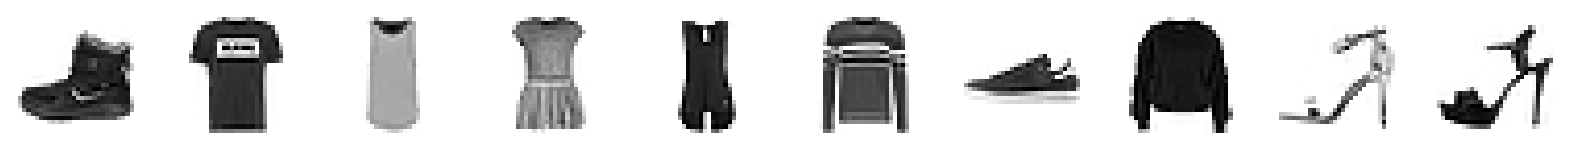

In [10]:
# show a selection of the training data
display(x_train)

## 2. Build the autoencoder

In [11]:
# ENCODER

encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name='encoder_input')

x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)[1:] # used by the decoder

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name='encoder_output')(x)

encoder = models.Model(encoder_input, encoder_output)

2023-07-27 11:42:45.112120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-27 11:42:45.130486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-27 11:42:45.130803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-27 11:42:45.131657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [12]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

In [14]:
# Decoder

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output',
)(x)

decoder = models.Model(decoder_input, decoder_output)

In [15]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 32)       1846

In [16]:
# Autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## 3. Train the Autoencoder

In [17]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
# create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./checkpoint',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0,
)

tensorboard_calback = callbacks.TensorBoard(log_dir='./logs')

In [19]:
stopwatch = Stopwatch()
stopwatch.start()

history = autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data = (x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_calback]
)

stopwatch.stop()

Start Time: Fri Jul 28 11:15:46 2023
Epoch 1/3


2023-07-28 11:15:48.692258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


596/600 [============================>.] - ETA: 0s - loss: 0.2883

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 14s 14ms/step - loss: 0.2882 - val_loss: 0.2604
Epoch 2/3
596/600 [============================>.] - ETA: 0s - loss: 0.2569

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 8s 14ms/step - loss: 0.2569 - val_loss: 0.2561
Epoch 3/3
596/600 [============================>.] - ETA: 0s - loss: 0.2539

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 8s 13ms/step - loss: 0.2539 - val_loss: 0.2542
End Time:   Fri Jul 28 11:16:16 2023
Elapsed seconds: 30.4437 (0.51 minutes)


Saved image: loss-20230728-111659.png


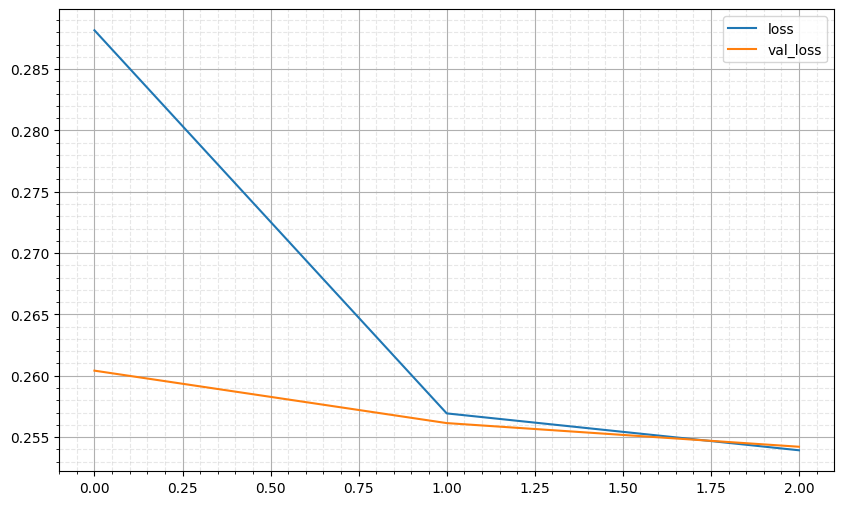

In [20]:
pch.show_history_chart(history, "loss", save_fig_enabled=True)

In [22]:
# Save the final models
autoencoder.save('./models/autoencoder')
encoder.save('./models/encoder')
decoder.save('./models/decoder')

INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


## 4. Reconstruct using the Autoencoder

In [23]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [26]:
stopwatch.start()

predictions = autoencoder.predict(example_images)

stopwatch.stop()

Start Time: Fri Jul 28 11:24:54 2023
157/157 [==============================] - 1s 4ms/step
End Time:   Fri Jul 28 11:24:55 2023
Elapsed seconds: 0.7390 (0.01 minutes)


Example real clothing items


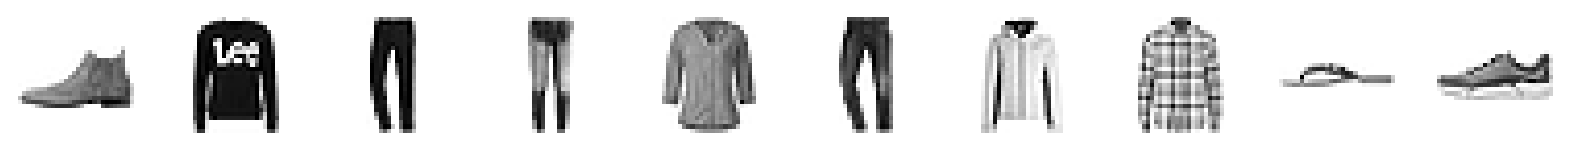

Reconstructions


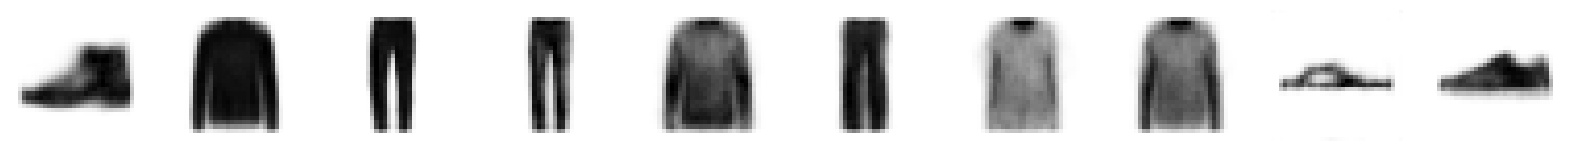

In [27]:
print('Example real clothing items')
display(example_images)

print('Reconstructions')
display(predictions)

## 5. Embed using the encoder

In [28]:
# encode the example images
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 1ms/step


In [29]:
# some examples of the embeddings
print(embeddings[:10])

[[ 1.4774444   1.7808644 ]
 [ 5.3706203  -3.209455  ]
 [-2.7692978  -6.016282  ]
 [-1.7565222  -3.450356  ]
 [ 3.1396108  -1.4021972 ]
 [-1.012376   -4.6297984 ]
 [ 1.3604308  -1.6464633 ]
 [ 2.3912556  -1.5636353 ]
 [-0.6918508   2.3847556 ]
 [ 0.75132626  3.4118414 ]]


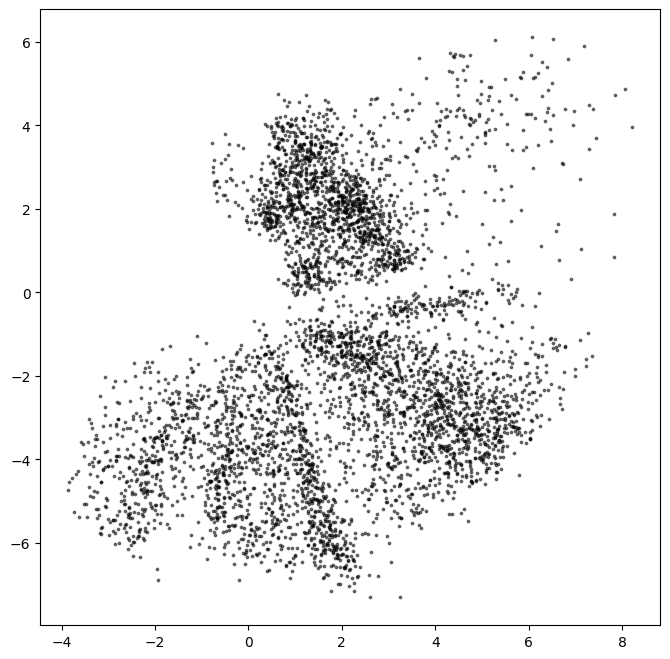

In [31]:
# show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

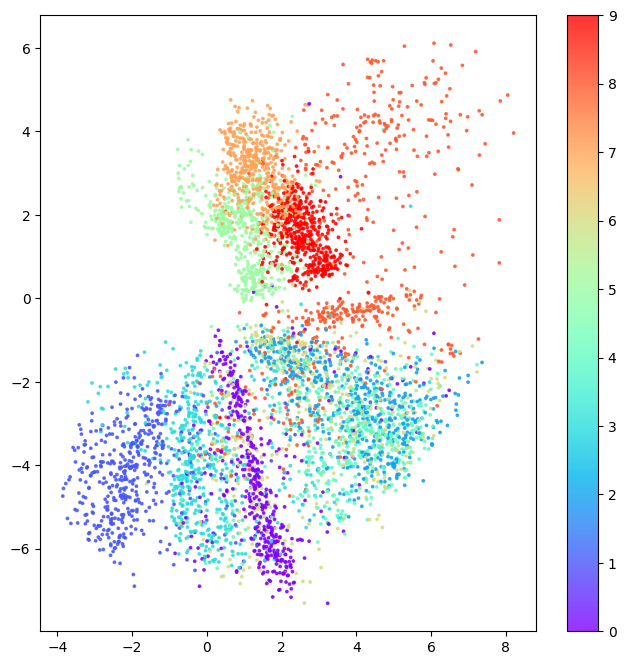

In [32]:
# color the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:,1],
    cmap='rainbow',
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

```
Table 3-3. The Fashion-MNIST labels 

ID  CLOTHING LABEL
0   T-shirt/top
1   Trouser
2   Pullover
3   Dress
4   Coat
5   Sandal
6   Shirt
7   Sneaker
8   Bag
9   Ankle boot
```

## 6. Generate using the decoder

In [33]:
# get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM))

In [34]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 333ms/step


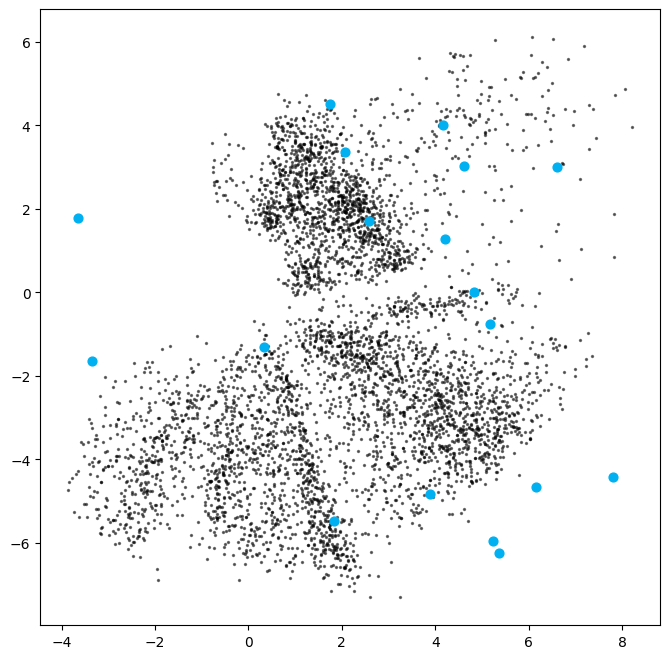

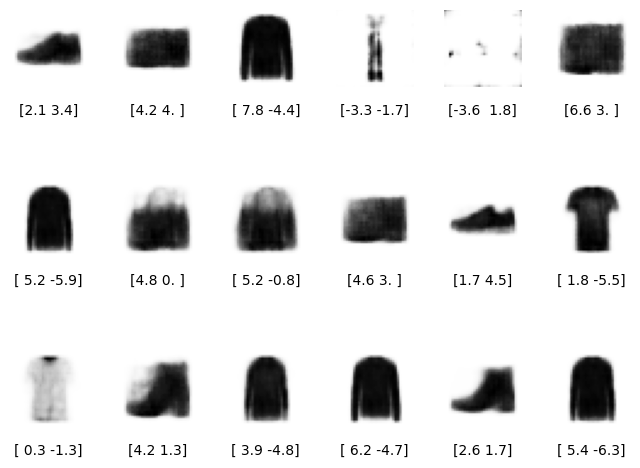

In [38]:
# draw a plot of the original embeddings
figsize = 8
plt.figure(figsize=(figsize, figsize))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=2)

# and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c='#00B0F0', alpha=1, s=40)
plt.show()

# with a grid of decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha='center',
        transform=ax.transAxes
    )
    ax.imshow(reconstructions[i, :, :], cmap='Greys')

8/8 [==============================] - 0s 48ms/step


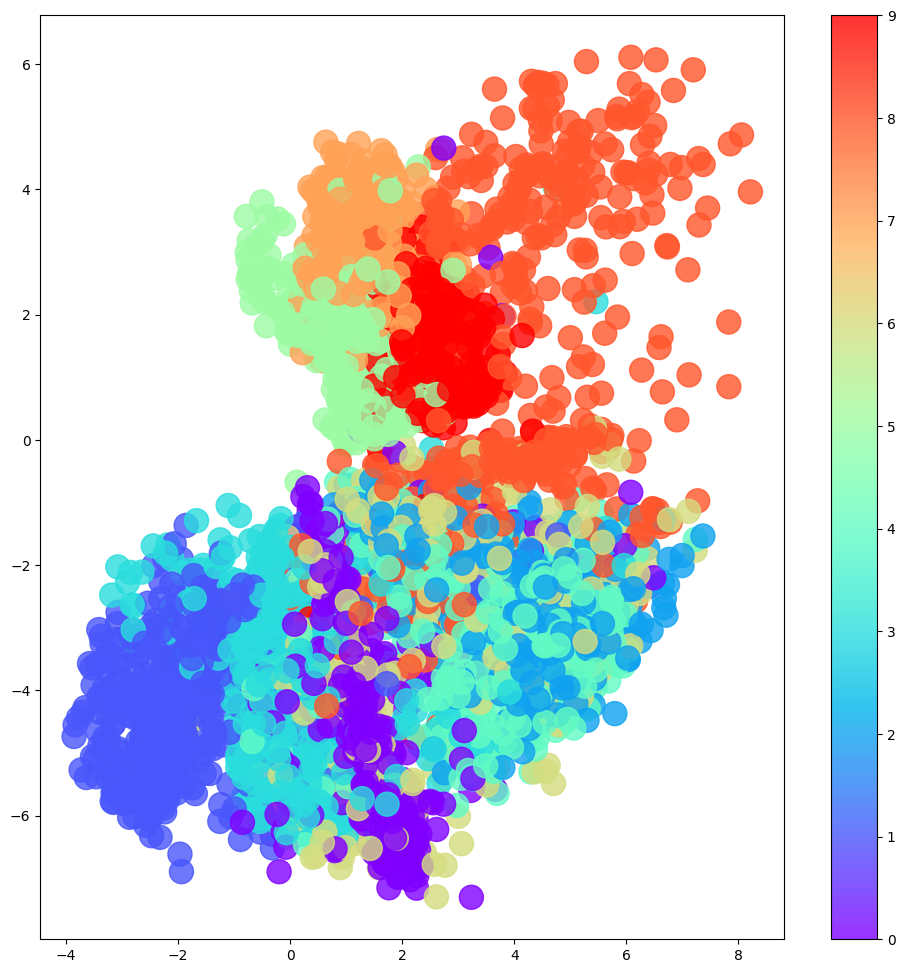

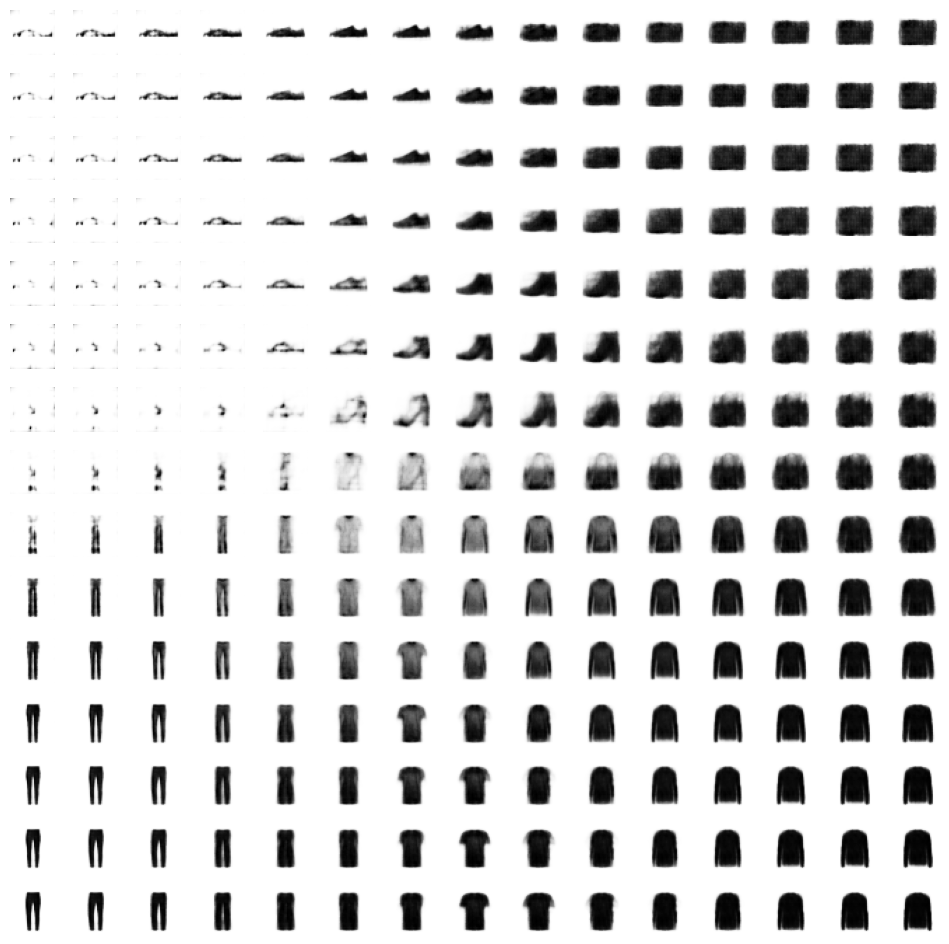

In [39]:

# color the embeddings by their label (clothing type - see table)

figsize = 12
grid_size = 15

plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap='rainbow',
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)

xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()

grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)

plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis('off')
    ax.imshow(reconstructions[i, :, :], cmap='Greys')